In [0]:
%tensorflow_version 1.x

TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
import warnings
warnings.filterwarnings("ignore")

!pip install -U git+https://github.com/qubvel/efficientnet

In [0]:
import efficientnet.keras as enet


In [0]:
import h5py
import numpy as np
import tensorflow as tf

filename = '/<path to dataset files>/h5/dataset_covidNet_BALANCED_2000.h5'

with h5py.File(filename, "r") as f:
    x_train = np.array(list(f['train_X']))
    y_train = np.array(list(f['train_y']))
    x_test = np.array(list(f['test_X']))
    y_test = np.array(list(f['test_y']))

import tensorflow as tf

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Converting class vectors to binary class matrices
num_classes = 3
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [0]:
# uses Swish Activation Function
from keras.backend import sigmoid
from keras.utils import get_custom_objects
from keras.layers import Activation

class SwishActivation(Activation):
    
    def __init__(self, activation, **kwargs):
        super(SwishActivation, self).__init__(activation, **kwargs)
        self.__name__ = 'swish_act'

def swish_act(x, beta = 1):
    return (x * sigmoid(beta * x))

get_custom_objects().update({'swish_act': SwishActivation(swish_act)})

In [0]:
from keras import layers
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

model = enet.EfficientNetB0(include_top=False, input_shape=(224,224,3), pooling='avg', weights='imagenet')

x = model.output

x = BatchNormalization()(x)
x = Dropout(0.7)(x)

x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)
x = Dropout(0.5)(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)

# Output layer
predictions = Dense(3, activation="softmax")(x)

model_final = Model(inputs = model.input, outputs = predictions)

model_final.summary()

In [0]:
from keras.callbacks import ModelCheckpoint

model_final.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.0001),
              metrics=['accuracy'])

mcp_save = ModelCheckpoint('/<path to save checkpoint models>/models/Efficient_c19.h5', save_best_only=True, monitor='val_acc')
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, verbose=1,)

model_final.fit(x_train, y_train,
              batch_size=32,
              epochs=10,
              validation_split=0.1,
              callbacks=[mcp_save, reduce_lr],
              shuffle=True,
              verbose=1)

210/210 [==============================] - 1s 5ms/step
Test Accuracy: 92.3809522106534%


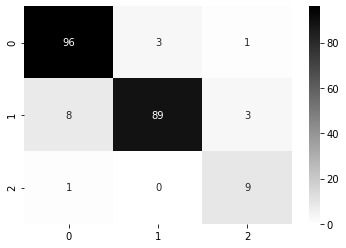

In [0]:
_, acc = model_final.evaluate(x_test, y_test)
print("Test Accuracy: {}%".format(acc*100))
import seaborn as sns
from sklearn.metrics import confusion_matrix

test_pred = model_final.predict(x_test)
import numpy as np

ax = sns.heatmap(confusion_matrix(np.argmax(y_test, axis=1),np.argmax(test_pred, axis=1)), cmap="binary",annot=True,fmt="d")